In [1]:
import torch
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import sys
sys.path.append('../src')
import pandas as pd
from strategies import *
import cv2
import numpy as np
import supervision as sv
from os.path import expanduser

In [2]:
home = expanduser("~")
main_path = home+"/Active-Learning-Segmentation/"
dataframes_path = main_path + "data/dataframes/"
sam_path = main_path + "sam/sam_vit_h_4b8939.pth"
notebooks_path = main_path + "scripts/notebooks/"
expirements_path = main_path+"expirements/"
sam_2_path = home+'/segment-anything-2'

In [3]:
sys.path.append(sam_2_path)
from PIL import Image
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2oracle import *

In [4]:
image_dim = 128

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sam = SAMOracle(checkpoint_path=sam_path, img_size=(image_dim,image_dim))
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    
sam2_checkpoint = sam_2_path + "/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"
sam_2 = SAM2Oracle(img_size=(image_dim,image_dim))


In [6]:
df = pd.read_csv(dataframes_path+"lung_df_test.csv")

In [7]:
import supervision as sv
images = []
gt_masks = []
for idx in range(30):
    images.append(cv2.resize(np.load(df["images"][idx], allow_pickle=True), (image_dim, image_dim), interpolation=cv2.INTER_CUBIC))
    gt_masks.append(cv2.resize(np.load(df["masks"][idx], allow_pickle=True), (image_dim, image_dim), interpolation=cv2.INTER_CUBIC))

0


1


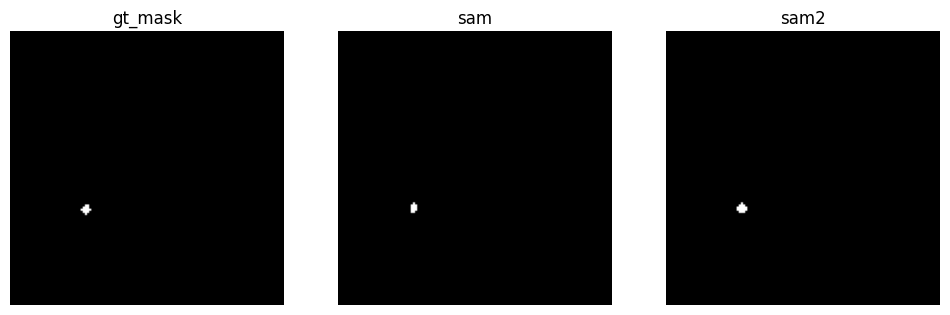

2


3


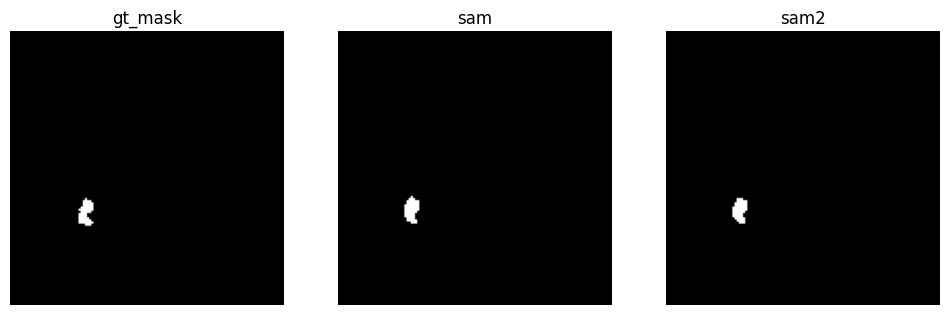

4


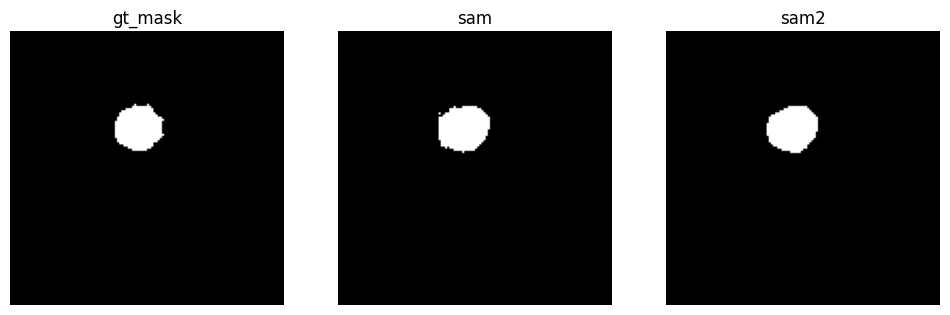

5


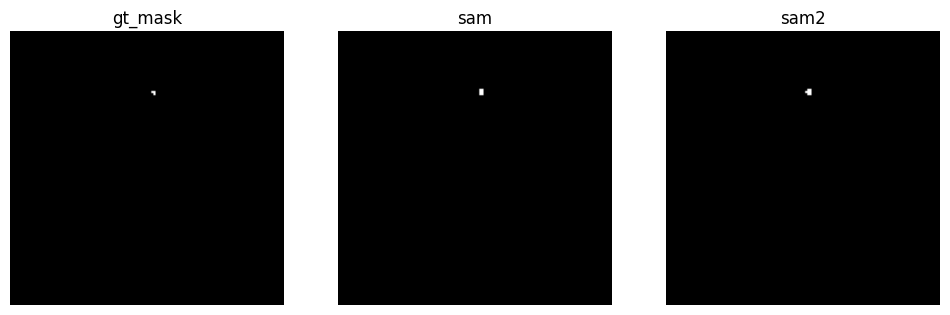

6


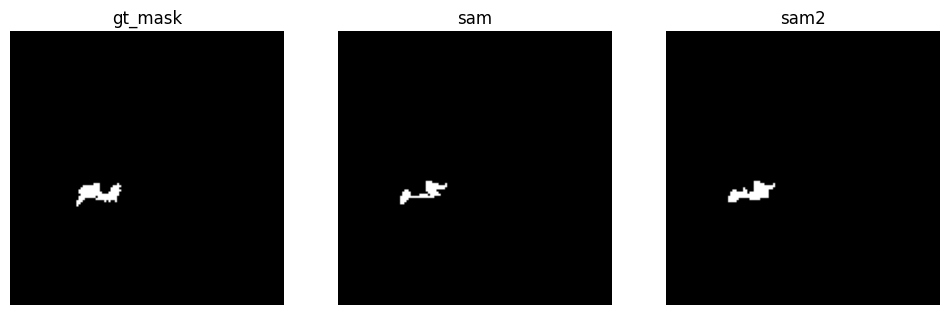

7


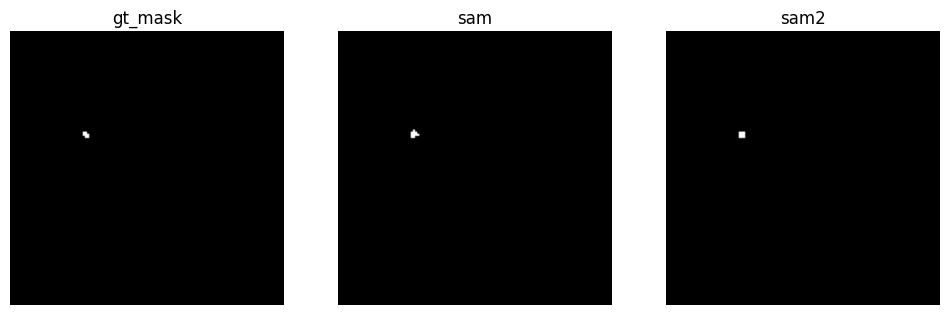

8


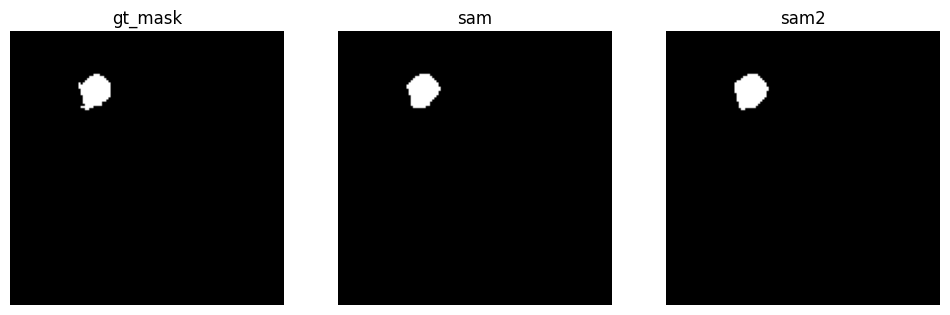

9


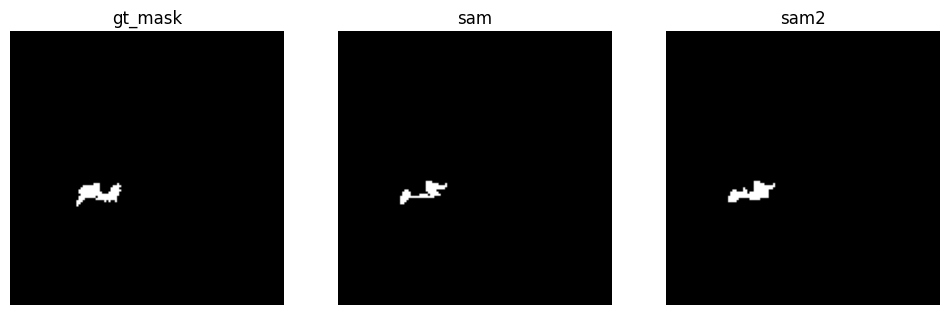

10


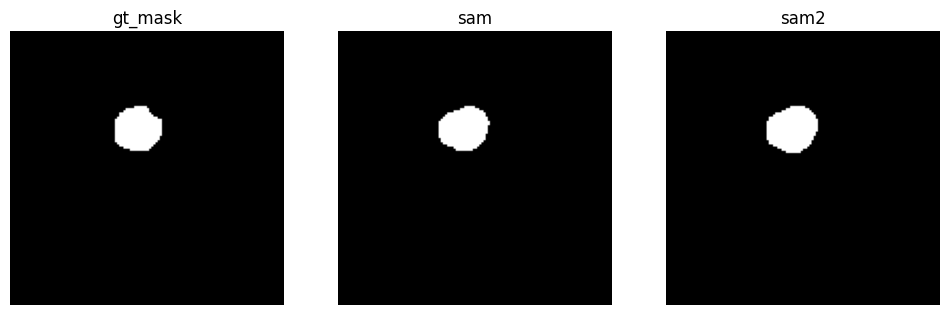

11


12


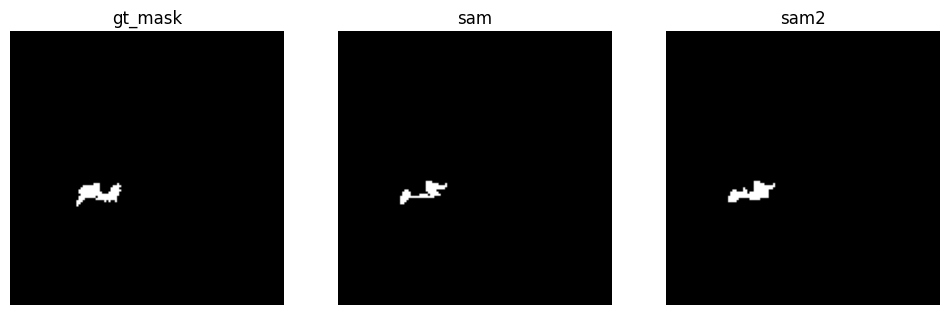

13


14


15


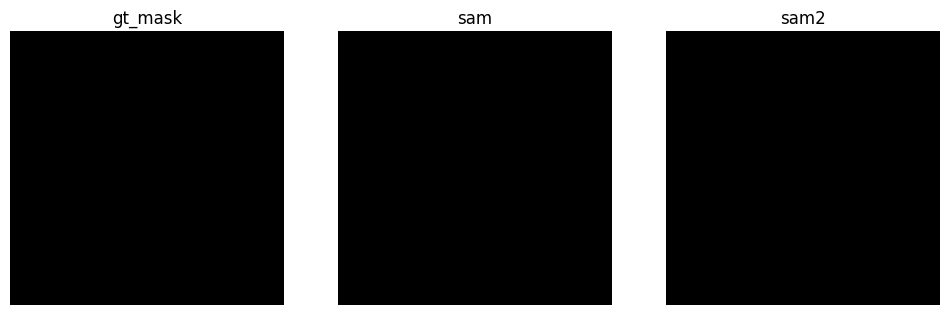

16


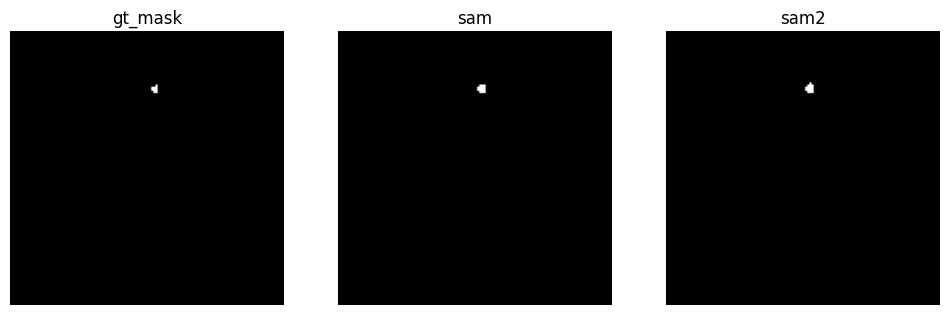

17


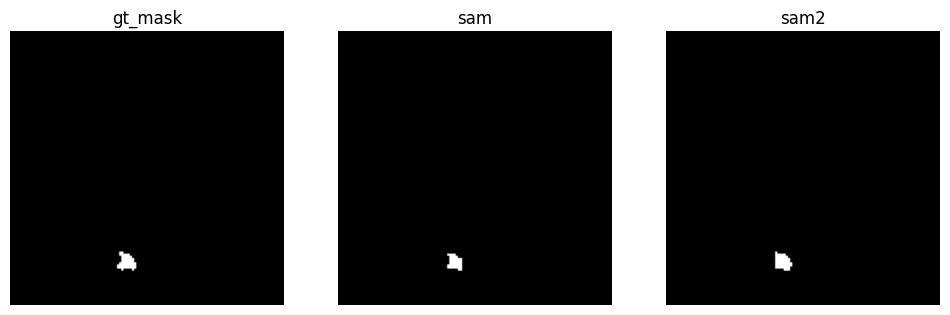

18


19


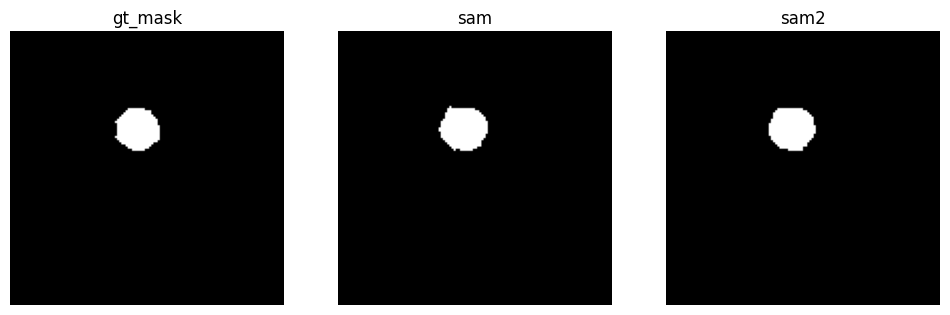

20


21


22


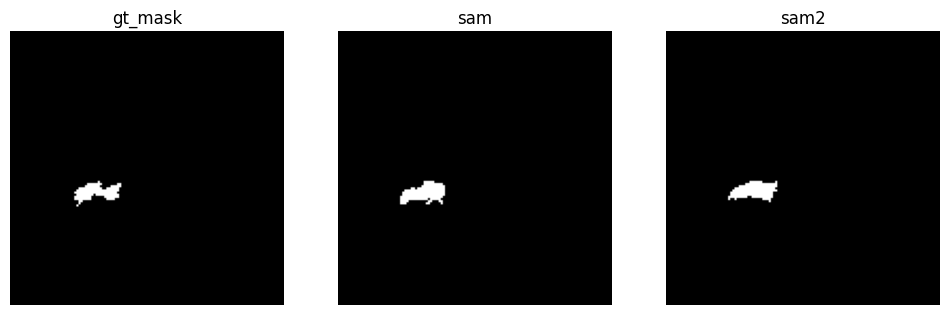

23


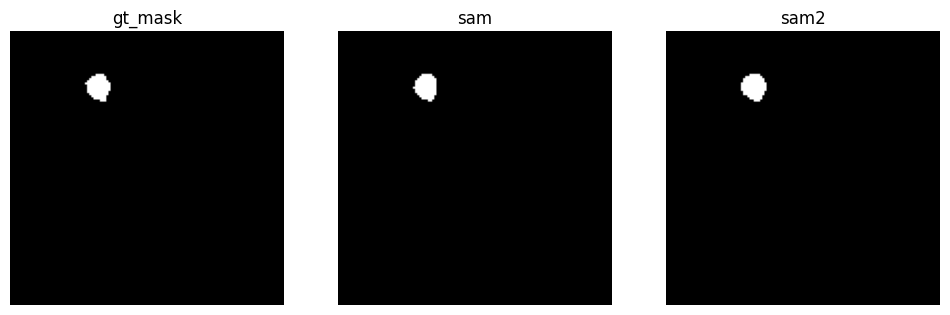

24


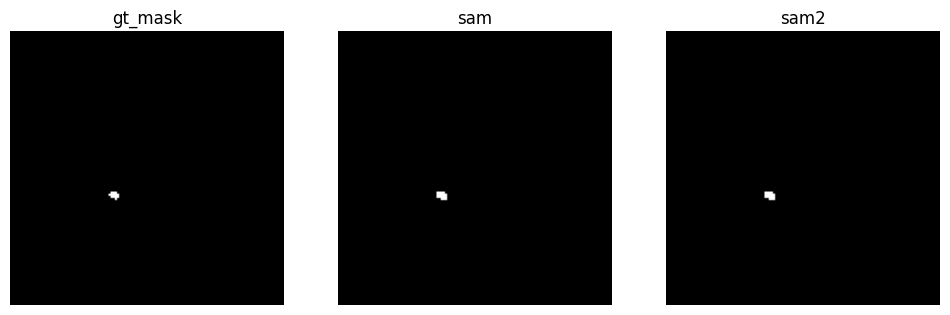

25


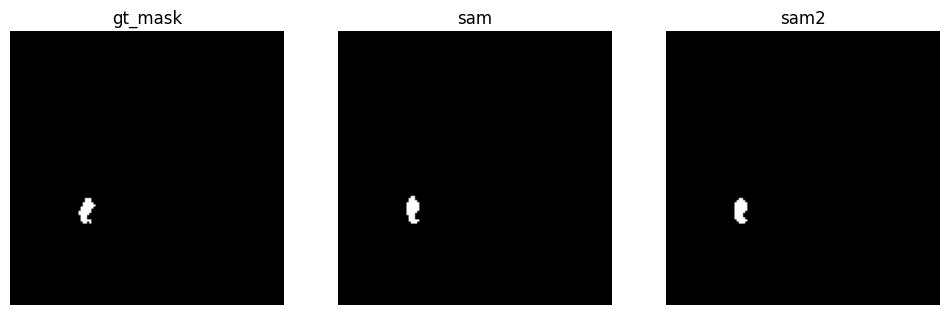

26


27


28


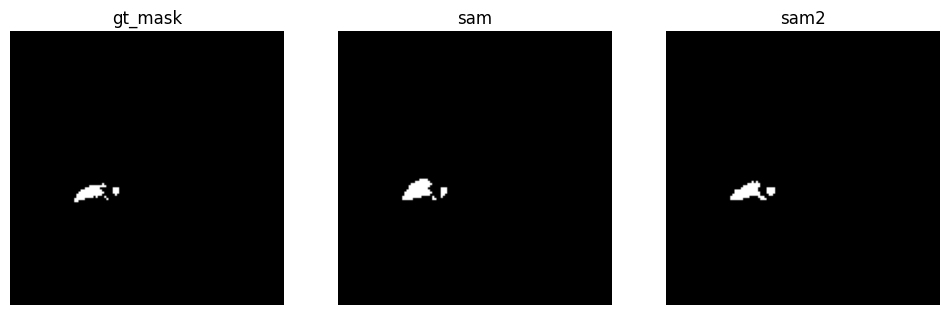

29


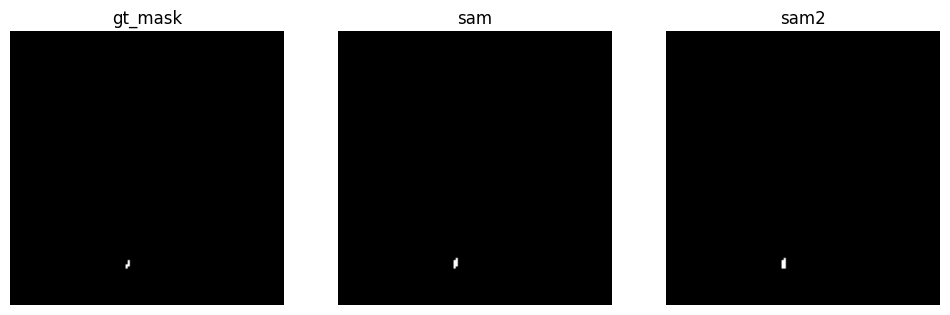

In [13]:
for idx in range(len(gt_masks)):
    print(idx)
    boxes1 = sam.get_boxes(gt_masks[idx])
    boxes2 = sam_2.get_boxes(gt_masks[idx])
    mask1 = sam.get_mask(img_path=df["images"][idx], boxes=boxes1).squeeze()
    mask2 = sam_2.get_mask(img_path=df["images"][idx], boxes=boxes2).squeeze()
    sv.plot_images_grid(
    images=[gt_masks[idx], mask1, mask2],
    grid_size=(1, 3),
    titles=['gt_mask', 'sam', "sam2"]
    )